# Import Library

In [1]:
import math
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
from scipy import stats

In [2]:
class Mancala:
    def __init__(self):
        self.board = [4]*6 + [0] + [4]*6 + [0]

    def clone(self):
        g = Mancala()
        g.board = self.board[:]
        return g

    def valid_moves(self, player):
        return [i for i in (range(0,6) if player==0 else range(7,13))
                if self.board[i] > 0]

    def apply_move(self, player, pit):
        new_board = self.clone()
        stones = new_board.board[pit]
        new_board.board[pit] = 0
        index = pit

        while stones > 0:
            index = (index + 1) % 14
            if (player==0 and index==13) or (player==1 and index==6):
                continue
            new_board.board[index] += 1
            stones -= 1

        if player==0 and 0 <= index < 6 and new_board.board[index] == 1:
            opp = 12 - index
            new_board.board[6] += new_board.board[opp] + 1
            new_board.board[index] = new_board.board[opp] = 0

        elif player==1 and 7 <= index < 13 and new_board.board[index] == 1:
            opp = 12 - index
            new_board.board[13] += new_board.board[opp] + 1
            new_board.board[index] = new_board.board[opp] = 0

        extra = (index == (6 if player==0 else 13))
        return new_board, extra

    def game_over(self):
        return (all(self.board[i]==0 for i in range(0,6)) or
                all(self.board[i]==0 for i in range(7,13)))

    def collect_remaining(self):
        if all(self.board[i]==0 for i in range(0,6)):
            for i in range(7,13):
                self.board[13] += self.board[i]
                self.board[i] = 0
        elif all(self.board[i]==0 for i in range(7,13)):
            for i in range(0,6):
                self.board[6] += self.board[i]
                self.board[i] = 0

    def score(self):
        return self.board[6], self.board[13]

In [3]:
def evaluate(board, player):
    b = board.board
    my_store  = b[6]  if player==0 else b[13]
    opp_store = b[13] if player==0 else b[6]
    my_side  = sum(b[0:6])  if player==0 else sum(b[7:13])
    opp_side = sum(b[7:13]) if player==0 else sum(b[0:6])

    store_diff = my_store - opp_store
    side_diff  = my_side - opp_side
    mobility   = len(board.valid_moves(player)) - len(board.valid_moves(1-player))

    total_stones = my_side + opp_side
    endgame_factor = 1.0 + (1 - total_stones/48.0) * 1.4

    return endgame_factor * (1.0*store_diff + 0.3*side_diff + 0.2*mobility)

In [4]:
def minimax(board, depth, player, current_player, node_stat):
    node_stat["nodes"] += 1

    if depth == 0 or board.game_over():
        return evaluate(board, player), None

    moves = board.valid_moves(current_player)
    if not moves:
        return evaluate(board, player), None

    maximizing = (current_player == player)
    best_move = None

    if maximizing:
        best_val = -math.inf
        for pit in moves:
            child, extra = board.apply_move(current_player, pit)
            next_p = current_player if extra else (1-current_player)
            val, _ = minimax(child, depth-1, player, next_p, node_stat)
            if val > best_val:
                best_val = val
                best_move = pit
        return best_val, best_move

    else:
        best_val = math.inf
        for pit in moves:
            child, extra = board.apply_move(current_player, pit)
            next_p = current_player if extra else (1-current_player)
            val, _ = minimax(child, depth-1, player, next_p, node_stat)
            if val < best_val:
                best_val = val
                best_move = pit
        return best_val, best_move

In [5]:
def alphabeta(board, depth, player, current_player, alpha, beta, node_stat):
    node_stat["nodes"] += 1
    if depth == 0 or board.game_over():
        return evaluate(board, player), None

    moves = board.valid_moves(current_player)
    if not moves:
        return evaluate(board, player), None

    maximizing = (current_player == player)
    best_move = None

    if maximizing:
        v = -math.inf
        for pit in moves:
            child, extra = board.apply_move(current_player, pit)
            next_p = current_player if extra else (1-current_player)
            val, _ = alphabeta(child, depth-1, player, next_p, alpha, beta, node_stat)
            if val > v:
                v = val
                best_move = pit
            alpha = max(alpha, v)
            if alpha >= beta:
                node_stat["cutoffs"] = node_stat.get("cutoffs", 0) + 1
                break
        return v, best_move

    else:
        v = math.inf
        for pit in moves:
            child, extra = board.apply_move(current_player, pit)
            next_p = current_player if extra else (1-current_player)
            val, _ = alphabeta(child, depth-1, player, next_p, alpha, beta, node_stat)
            if val < v:
                v = val
                best_move = pit
            beta = min(beta, v)
            if alpha >= beta:
                node_stat["cutoffs"] = node_stat.get("cutoffs", 0) + 1
                break
        return v, best_move

In [6]:
def minimax_move(board, depth, player):
    stat = {"nodes": 0}
    t0 = time.time()
    val, move = minimax(board, depth, player, player, stat)
    t_total = time.time() - t0
    return val, move, stat, t_total

def alphabeta_move(board, depth, player):
    stat = {"nodes": 0, "cutoffs": 0}
    t0 = time.time()
    val, move = alphabeta(board, depth, player, player, -math.inf, math.inf, stat)
    t_total = time.time() - t0
    return val, move, stat, t_total

In [7]:
def run_random_depth_benchmark(num_games=30, min_minimax=3, max_minimax=7, min_ab=3, max_ab=10):
    print(f"\n{'='*70}")
    print(f"BENCHMARK 1: Random Depth Comparison (Time-Constrained Scenario)")
    print(f"{'='*70}")
    print(f"Running {num_games} games...")

    results = []
    for gid in range(1, num_games+1):
        if gid % 10 == 0:
            print(f"  Progress: {gid}/{num_games} games completed")

        fp = random.choice([0,1])
        dmm = random.randint(min_minimax, max_minimax)
        dab = random.randint(min_ab, max_ab)

        game = Mancala()
        current = fp
        nodes_mm = nodes_ab = 0
        cutoffs_ab = 0
        time_mm = time_ab = 0
        moves_mm = moves_ab = 0

        while not game.game_over():
            if current == 0:
                val, pit, stat, t = minimax_move(game, dmm, 0)
                nodes_mm += stat["nodes"]
                time_mm  += t
                moves_mm += 1
            else:
                val, pit, stat, t = alphabeta_move(game, dab, 1)
                nodes_ab += stat["nodes"]
                cutoffs_ab += stat.get("cutoffs", 0)
                time_ab  += t
                moves_ab += 1

            if pit is None:
                break

            game, extra = game.apply_move(current, pit)
            if not extra:
                current = 1-current

        game.collect_remaining()
        p0, p1 = game.score()

        results.append({
            "Game": gid,
            "First_Player": "Minimax" if fp==0 else "Alpha-Beta",
            "Depth_Minimax": dmm,
            "Depth_AlphaBeta": dab,
            "Nodes_Minimax": nodes_mm,
            "Nodes_AlphaBeta": nodes_ab,
            "Cutoffs_AlphaBeta": cutoffs_ab,
            "Time_Minimax": time_mm,
            "Time_AlphaBeta": time_ab,
            "Moves_Minimax": moves_mm,
            "Moves_AlphaBeta": moves_ab,
            "Avg_Nodes_Per_Move_MM": nodes_mm / max(moves_mm, 1),
            "Avg_Nodes_Per_Move_AB": nodes_ab / max(moves_ab, 1),
            "Score_MM": p0,
            "Score_AB": p1,
            "Winner": "Minimax" if p0>p1 else ("Alpha-Beta" if p1>p0 else "Draw"),
            "Score_Diff": abs(p0 - p1)
        })

    df = pd.DataFrame(results)
    print(f"✓ Completed {num_games} games")
    print_summary_stats(df, "Random Depth")
    return df

In [8]:
def run_same_depth_benchmark(num_games=50, test_depths=[3, 4, 5, 6]):
    """Benchmark dengan depth yang sama untuk kedua algoritma"""
    print(f"\n{'='*70}")
    print(f"BENCHMARK 2: Same Depth Analysis (Algorithm Correctness)")
    print(f"{'='*70}")

    results = []

    for depth in test_depths:
        print(f"\nTesting depth {depth}... ({num_games} games)")

        for gid in range(num_games):
            fp = gid % 2

            game = Mancala()
            current = fp

            nodes_mm = nodes_ab = 0
            cutoffs_ab = 0
            time_mm = time_ab = 0
            moves_mm = moves_ab = 0

            while not game.game_over():
                is_mm_turn = (current == 0 and fp == 0) or (current == 1 and fp == 1)

                if is_mm_turn:
                    val, pit, stat, t = minimax_move(game, depth, current)
                    nodes_mm += stat["nodes"]
                    time_mm += t
                    moves_mm += 1
                else:
                    val, pit, stat, t = alphabeta_move(game, depth, current)
                    nodes_ab += stat["nodes"]
                    cutoffs_ab += stat.get("cutoffs", 0)
                    time_ab += t
                    moves_ab += 1

                if pit is None:
                    break

                game, extra = game.apply_move(current, pit)
                if not extra:
                    current = 1 - current

            game.collect_remaining()
            score_p0, score_p1 = game.score()

            if fp == 0:
                score_mm, score_ab = score_p0, score_p1
            else:
                score_mm, score_ab = score_p1, score_p0

            winner = "Minimax" if score_mm > score_ab else ("Alpha-Beta" if score_ab > score_mm else "Draw")

            results.append({
                "Game": gid + 1,
                "Depth": depth,
                "First_Player": "Minimax" if fp==0 else "Alpha-Beta",
                "Nodes_Minimax": nodes_mm,
                "Nodes_AlphaBeta": nodes_ab,
                "Cutoffs_AlphaBeta": cutoffs_ab,
                "Time_Minimax": time_mm,
                "Time_AlphaBeta": time_ab,
                "Moves_Minimax": moves_mm,
                "Moves_AlphaBeta": moves_ab,
                "Score_MM": score_mm,
                "Score_AB": score_ab,
                "Winner": winner
            })

    df = pd.DataFrame(results)
    print(f"\n✓ Completed same-depth analysis")
    print_summary_stats(df, "Same Depth")
    return df

In [9]:
def print_summary_stats(df, benchmark_name):
    """Print summary statistics"""
    print(f"\n{'='*70}")
    print(f"{benchmark_name.upper()} SUMMARY")
    print(f"{'='*70}")

    if "Depth_Minimax" in df.columns:
        print(f"\nDEPTH STATISTICS:")
        print(f"   Minimax depths range:    {df['Depth_Minimax'].min()}-{df['Depth_Minimax'].max()} (avg: {df['Depth_Minimax'].mean():.2f})")
        print(f"   Alpha-Beta depths range: {df['Depth_AlphaBeta'].min()}-{df['Depth_AlphaBeta'].max()} (avg: {df['Depth_AlphaBeta'].mean():.2f})")
        print(f"   Depth advantage (AB):    +{df['Depth_AlphaBeta'].mean() - df['Depth_Minimax'].mean():.2f} levels deeper")

        print(f"\nDEPTH MATCHUP FREQUENCY:")
        depth_matchup = pd.crosstab(df['Depth_Minimax'], df['Depth_AlphaBeta'],
                                     rownames=['MM Depth'], colnames=['AB Depth'], margins=True)
        print(depth_matchup.to_string())

    print(f"\nEFFICIENCY METRICS:")
    print(f"   {'Metric':<30} {'Minimax':>15} {'Alpha-Beta':>15} {'Improvement':>15}")
    print(f"   {'-'*30} {'-'*15} {'-'*15} {'-'*15}")
    print(f"   {'Avg Nodes Visited':<30} {df['Nodes_Minimax'].mean():>15,.0f} {df['Nodes_AlphaBeta'].mean():>15,.0f} {(1 - df['Nodes_AlphaBeta'].mean()/df['Nodes_Minimax'].mean())*100:>14.1f}%")
    print(f"   {'Avg Time (seconds)':<30} {df['Time_Minimax'].mean():>15.3f} {df['Time_AlphaBeta'].mean():>15.3f} {df['Time_Minimax'].mean()/df['Time_AlphaBeta'].mean():>14.2f}x")

    if 'Moves_Minimax' in df.columns:
        avg_nodes_per_move_mm = df['Nodes_Minimax'].sum() / df['Moves_Minimax'].sum() if df['Moves_Minimax'].sum() > 0 else 0
        avg_nodes_per_move_ab = df['Nodes_AlphaBeta'].sum() / df['Moves_AlphaBeta'].sum() if df['Moves_AlphaBeta'].sum() > 0 else 0
        nodes_per_move_reduction = (1 - avg_nodes_per_move_ab/avg_nodes_per_move_mm)*100 if avg_nodes_per_move_mm > 0 else 0

        print(f"   {'Avg Moves Played':<30} {df['Moves_Minimax'].mean():>15.1f} {df['Moves_AlphaBeta'].mean():>15.1f} {'-':>15}")
        print(f"   {'Avg Nodes/Move':<30} {avg_nodes_per_move_mm:>15,.0f} {avg_nodes_per_move_ab:>15,.0f} {nodes_per_move_reduction:>14.1f}%")

    print(f"\nGAME RESULTS:")
    win_counts = df['Winner'].value_counts()
    total_games = len(df)
    print(f"   {'Algorithm':<20} {'Wins':>10} {'Win Rate':>12} {'Avg Score':>12}")
    print(f"   {'-'*20} {'-'*10} {'-'*12} {'-'*12}")
    print(f"   {'Minimax':<20} {win_counts.get('Minimax', 0):>10} {win_counts.get('Minimax', 0)/total_games*100:>11.1f}% {df['Score_MM'].mean():>12.1f}")
    print(f"   {'Alpha-Beta':<20} {win_counts.get('Alpha-Beta', 0):>10} {win_counts.get('Alpha-Beta', 0)/total_games*100:>11.1f}% {df['Score_AB'].mean():>12.1f}")
    print(f"   {'Draw':<20} {win_counts.get('Draw', 0):>10} {win_counts.get('Draw', 0)/total_games*100:>11.1f}% {'-':>12}")
    print(f"   {'-'*20} {'-'*10} {'-'*12} {'-'*12}")
    print(f"   {'TOTAL':<20} {total_games:>10} {'100.0%':>12} {'-':>12}")

    if 'Cutoffs_AlphaBeta' in df.columns:
        print(f"\nPRUNING STATISTICS:")
        print(f"   Total Alpha-Beta cutoffs: {df['Cutoffs_AlphaBeta'].sum():,.0f}")
        print(f"   Avg cutoffs per game:     {df['Cutoffs_AlphaBeta'].mean():,.0f}")
        print(f"   Cutoff efficiency:        {df['Cutoffs_AlphaBeta'].sum() / df['Nodes_AlphaBeta'].sum() * 100:.1f}% of nodes led to cutoffs")

In [10]:
def create_comprehensive_visualizations(df_random, df_same):
    sns.set_theme(style="whitegrid", context="notebook", font_scale=0.9)
    palette = {"Minimax": "#E63946", "Alpha-Beta": "#1D3557", "Draw": "#A8DADC"}

    fig1 = plt.figure(figsize=(22, 14))
    gs1 = fig1.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    fig1.suptitle('🎲 Random Depth Benchmark: Time-Constrained Competition',
                  fontsize=20, fontweight='bold', y=0.98)

    ax1 = fig1.add_subplot(gs1[0, 0])
    ax1.plot(df_random["Game"], df_random["Nodes_Minimax"], 'o-',
             color=palette["Minimax"], label="Minimax", linewidth=2, markersize=4)
    ax1.plot(df_random["Game"], df_random["Nodes_AlphaBeta"], 's-',
             color=palette["Alpha-Beta"], label="Alpha-Beta", linewidth=2, markersize=4)
    ax1.fill_between(df_random["Game"], df_random["Nodes_AlphaBeta"],
                     df_random["Nodes_Minimax"], color='green', alpha=0.1)
    avg_reduction = (1 - df_random["Nodes_AlphaBeta"].mean()/df_random["Nodes_Minimax"].mean())*100
    ax1.set_title(f"Nodes Visited per Game\n(Avg Reduction: {avg_reduction:.1f}%)", fontweight="bold")
    ax1.set_xlabel("Game Number")
    ax1.set_ylabel("Nodes Visited")
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)

    ax2 = fig1.add_subplot(gs1[0, 1])
    df_time_melt = df_random.melt(id_vars=["Game"],
                                   value_vars=["Time_Minimax", "Time_AlphaBeta"],
                                   var_name="Algorithm", value_name="Time")
    df_time_melt["Algorithm"] = df_time_melt["Algorithm"].map({
        "Time_Minimax": "Minimax", "Time_AlphaBeta": "Alpha-Beta"})
    x_pos = np.arange(len(df_random))
    width = 0.35
    ax2.bar(x_pos - width/2, df_random["Time_Minimax"], width,
            label="Minimax", color=palette["Minimax"], alpha=0.8)
    ax2.bar(x_pos + width/2, df_random["Time_AlphaBeta"], width,
            label="Alpha-Beta", color=palette["Alpha-Beta"], alpha=0.8)
    avg_speedup = df_random['Time_Minimax'].mean() / df_random['Time_AlphaBeta'].mean()
    ax2.set_title(f"Execution Time per Game\n(Alpha-Beta {avg_speedup:.1f}x Faster)", fontweight="bold")
    ax2.set_xlabel("Game Number")
    ax2.set_ylabel("Time (seconds)")
    ax2.legend()
    ax2.set_xticks([0, len(df_random)//2, len(df_random)-1])
    ax2.grid(True, alpha=0.3, axis='y')

    ax3 = fig1.add_subplot(gs1[0, 2])
    scatter = ax3.scatter(df_random["Depth_Minimax"], df_random["Depth_AlphaBeta"],
                alpha=0.6, s=100, c=df_random.index, cmap='viridis',
                edgecolors='black', linewidth=0.8)
    ax3.plot([3, 10], [3, 10], 'r--', linewidth=2.5, label='Equal Depth', alpha=0.7)

    for idx, row in df_random.iterrows():
        if row['Depth_AlphaBeta'] - row['Depth_Minimax'] >= 4:
            ax3.annotate(f"Game {row['Game']}",
                        xy=(row['Depth_Minimax'], row['Depth_AlphaBeta']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=7, alpha=0.7,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

    ax3.set_xlabel("Minimax Depth", fontweight='bold')
    ax3.set_ylabel("Alpha-Beta Depth", fontweight='bold')
    ax3.set_title("Depth Pairing Distribution\n(Points above red line = AB deeper)",
                 fontweight="bold", fontsize=10)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3, label='Game Order')

    depth_diff = df_random['Depth_AlphaBeta'].mean() - df_random['Depth_Minimax'].mean()
    textstr = f'Avg AB advantage:\n+{depth_diff:.2f} levels'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

    ax4 = fig1.add_subplot(gs1[1, 0])
    win_counts = df_random["Winner"].value_counts()
    colors_pie = [palette.get(x, "#999999") for x in win_counts.index]

    wedges, texts, autotexts = ax4.pie(win_counts, labels=None,
                                         autopct='', startangle=90,
                                         colors=colors_pie,
                                         wedgeprops={'edgecolor': 'white', 'linewidth': 3},
                                         textprops={'fontsize': 11, 'fontweight': 'bold'})

    for i, (label, count) in enumerate(win_counts.items()):
        pct = count / len(df_random) * 100
        wedges[i].set_label(f'{label}: {count} ({pct:.1f}%)')

    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax4.add_artist(centre_circle)

    total = len(df_random)
    ax4.text(0, 0, f'{total}\nGames', ha='center', va='center',
            fontsize=16, fontweight='bold', color='#333')

    ax4.set_title("Win Distribution", fontweight="bold", fontsize=11, pad=20)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

    ax5 = fig1.add_subplot(gs1[1, 1])
    df_random['Cum_Score_MM'] = df_random['Score_MM'].cumsum()
    df_random['Cum_Score_AB'] = df_random['Score_AB'].cumsum()
    ax5.plot(df_random["Game"], df_random["Cum_Score_MM"],
             color=palette["Minimax"], linewidth=3, label="Minimax")
    ax5.plot(df_random["Game"], df_random["Cum_Score_AB"],
             color=palette["Alpha-Beta"], linewidth=3, label="Alpha-Beta")
    ax5.fill_between(df_random["Game"], df_random["Cum_Score_MM"],
                     df_random["Cum_Score_AB"], alpha=0.2)
    ax5.set_title("Cumulative Score Progress", fontweight="bold")
    ax5.set_xlabel("Game Number")
    ax5.set_ylabel("Total Score")
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    ax6 = fig1.add_subplot(gs1[1, 2])
    if 'Cutoffs_AlphaBeta' in df_random.columns:
        ax6.scatter(df_random["Nodes_AlphaBeta"], df_random["Cutoffs_AlphaBeta"],
                   alpha=0.6, s=80, c=df_random["Depth_AlphaBeta"],
                   cmap='plasma', edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(ax6.collections[0], ax=ax6, label='AB Depth')
        ax6.set_xlabel("Nodes Visited (Alpha-Beta)")
        ax6.set_ylabel("Cutoffs Performed")
        ax6.set_title("Alpha-Beta Pruning Efficiency", fontweight="bold")
        ax6.grid(True, alpha=0.3)

    ax7 = fig1.add_subplot(gs1[2, 0])
    depth_groups_mm = df_random.groupby("Depth_Minimax").agg({
        "Time_Minimax": ["mean", "std"],
        "Nodes_Minimax": "mean"
    }).reset_index()
    ax7.errorbar(depth_groups_mm["Depth_Minimax"],
                depth_groups_mm["Time_Minimax"]["mean"],
                yerr=depth_groups_mm["Time_Minimax"]["std"],
                fmt='o-', color=palette["Minimax"], linewidth=2,
                markersize=8, capsize=5, capthick=2)
    ax7.set_xlabel("Search Depth")
    ax7.set_ylabel("Average Time (seconds)")
    ax7.set_title("Minimax: Time Complexity by Depth", fontweight="bold")
    ax7.set_yscale('log')
    ax7.grid(True, alpha=0.3)

    ax8 = fig1.add_subplot(gs1[2, 1])
    depth_groups_ab = df_random.groupby("Depth_AlphaBeta").agg({
        "Time_AlphaBeta": ["mean", "std"],
        "Nodes_AlphaBeta": "mean"
    }).reset_index()
    ax8.errorbar(depth_groups_ab["Depth_AlphaBeta"],
                depth_groups_ab["Time_AlphaBeta"]["mean"],
                yerr=depth_groups_ab["Time_AlphaBeta"]["std"],
                fmt='s-', color=palette["Alpha-Beta"], linewidth=2,
                markersize=8, capsize=5, capthick=2)
    ax8.set_xlabel("Search Depth")
    ax8.set_ylabel("Average Time (seconds)")
    ax8.set_title("Alpha-Beta: Time Complexity by Depth", fontweight="bold")
    ax8.set_yscale('log')
    ax8.grid(True, alpha=0.3)

    ax9 = fig1.add_subplot(gs1[2, 2])

    depth_matchup = pd.crosstab(df_random["Depth_Minimax"],
                                df_random["Depth_AlphaBeta"])

    sns.heatmap(depth_matchup, annot=True, fmt='d', cmap='YlOrRd',
                cbar_kws={'label': 'Frequency'}, ax=ax9,
                linewidths=1, linecolor='white')

    ax9.set_xlabel("Alpha-Beta Depth", fontweight='bold')
    ax9.set_ylabel("Minimax Depth", fontweight='bold')
    ax9.set_title("Depth Matchup Frequency Heatmap\n(How often each depth pair occurred)",
                 fontweight="bold", fontsize=10)

    ax9.set_xticklabels(ax9.get_xticklabels(), rotation=0)
    ax9.set_yticklabels(ax9.get_yticklabels(), rotation=0)

    plt.tight_layout()

    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle('Same Depth Analysis: Algorithm Correctness & Efficiency',
                  fontsize=18, fontweight='bold', y=0.98)

    ax21 = axes2[0, 0]
    depth_analysis = df_same.groupby("Depth").agg({
        "Nodes_Minimax": "mean",
        "Nodes_AlphaBeta": "mean"
    }).reset_index()
    x = depth_analysis["Depth"]
    width = 0.35
    x_pos = np.arange(len(x))
    ax21.bar(x_pos - width/2, depth_analysis["Nodes_Minimax"], width,
            label="Minimax", color=palette["Minimax"], alpha=0.8)
    ax21.bar(x_pos + width/2, depth_analysis["Nodes_AlphaBeta"], width,
            label="Alpha-Beta", color=palette["Alpha-Beta"], alpha=0.8)
    ax21.set_xlabel("Search Depth")
    ax21.set_ylabel("Average Nodes Visited")
    ax21.set_title("Nodes Visited at Same Depth", fontweight="bold")
    ax21.set_xticks(x_pos)
    ax21.set_xticklabels(x)
    ax21.legend()
    ax21.set_yscale('log')
    ax21.grid(True, alpha=0.3, axis='y')

    ax22 = axes2[0, 1]
    depth_analysis["Pruning_Efficiency"] = (1 - depth_analysis["Nodes_AlphaBeta"] /
                                            depth_analysis["Nodes_Minimax"]) * 100
    ax22.plot(depth_analysis["Depth"], depth_analysis["Pruning_Efficiency"],
             'go-', linewidth=3, markersize=10)
    ax22.axhline(y=50, color='r', linestyle='--', linewidth=2, label="50% Baseline")
    ax22.set_xlabel("Search Depth")
    ax22.set_ylabel("Nodes Pruned (%)")
    ax22.set_title("Alpha-Beta Pruning Efficiency by Depth", fontweight="bold")
    ax22.legend()
    ax22.grid(True, alpha=0.3)
    ax22.set_ylim([0, 100])

    ax23 = axes2[1, 0]
    win_by_depth = pd.crosstab(df_same["Depth"], df_same["Winner"], normalize='index') * 100
    win_by_depth.plot(kind='bar', ax=ax23,
                     color=[palette.get(x, "#999999") for x in win_by_depth.columns],
                     rot=0, width=0.7)
    ax23.set_xlabel("Search Depth")
    ax23.set_ylabel("Win Rate (%)")
    ax23.set_title("Win Distribution by Depth (Same Depth)", fontweight="bold")
    ax23.legend(title="Winner")
    ax23.grid(True, alpha=0.3, axis='y')

    ax24 = axes2[1, 1]
    time_analysis = df_same.groupby("Depth").agg({
        "Time_Minimax": "mean",
        "Time_AlphaBeta": "mean"
    }).reset_index()
    ax24.plot(time_analysis["Depth"], time_analysis["Time_Minimax"],
             'o-', color=palette["Minimax"], linewidth=3, markersize=10, label="Minimax")
    ax24.plot(time_analysis["Depth"], time_analysis["Time_AlphaBeta"],
             's-', color=palette["Alpha-Beta"], linewidth=3, markersize=10, label="Alpha-Beta")
    ax24.set_xlabel("Search Depth")
    ax24.set_ylabel("Average Time (seconds)")
    ax24.set_title("Time Comparison at Same Depth", fontweight="bold")
    ax24.legend()
    ax24.set_yscale('log')
    ax24.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig1, fig2

In [11]:
def create_summary_tables(df_random, df_same):
    avg_nodes_per_move_mm = df_random['Nodes_Minimax'].sum() / df_random['Moves_Minimax'].sum() if df_random['Moves_Minimax'].sum() > 0 else 0
    avg_nodes_per_move_ab = df_random['Nodes_AlphaBeta'].sum() / df_random['Moves_AlphaBeta'].sum() if df_random['Moves_AlphaBeta'].sum() > 0 else 0

    summary_random = pd.DataFrame({
        'Metric': [
            'Total Games',
            'Minimax Wins',
            'Alpha-Beta Wins',
            'Draws',
            'Minimax Win Rate (%)',
            'Alpha-Beta Win Rate (%)',
            'Draw Rate (%)',
            'Avg Minimax Depth',
            'Avg Alpha-Beta Depth',
            'Depth Advantage (AB)',
            'Min Minimax Depth',
            'Max Minimax Depth',
            'Min Alpha-Beta Depth',
            'Max Alpha-Beta Depth',
            'Avg Minimax Nodes',
            'Avg Alpha-Beta Nodes',
            'Node Reduction (%)',
            'Avg Nodes/Move (MM)',
            'Avg Nodes/Move (AB)',
            'Avg Minimax Time (s)',
            'Avg Alpha-Beta Time (s)',
            'Speedup Factor',
            'Total Alpha-Beta Cutoffs',
            'Avg Cutoffs per Game',
            'Avg Score Minimax',
            'Avg Score Alpha-Beta',
            'Avg Score Difference'
        ],
        'Value': [
            len(df_random),
            (df_random['Winner'] == 'Minimax').sum(),
            (df_random['Winner'] == 'Alpha-Beta').sum(),
            (df_random['Winner'] == 'Draw').sum(),
            (df_random['Winner'] == 'Minimax').mean() * 100,
            (df_random['Winner'] == 'Alpha-Beta').mean() * 100,
            (df_random['Winner'] == 'Draw').mean() * 100,
            df_random['Depth_Minimax'].mean(),
            df_random['Depth_AlphaBeta'].mean(),
            df_random['Depth_AlphaBeta'].mean() - df_random['Depth_Minimax'].mean(),
            df_random['Depth_Minimax'].min(),
            df_random['Depth_Minimax'].max(),
            df_random['Depth_AlphaBeta'].min(),
            df_random['Depth_AlphaBeta'].max(),
            df_random['Nodes_Minimax'].mean(),
            df_random['Nodes_AlphaBeta'].mean(),
            (1 - df_random['Nodes_AlphaBeta'].mean() / df_random['Nodes_Minimax'].mean()) * 100,
            avg_nodes_per_move_mm,
            avg_nodes_per_move_ab,
            df_random['Time_Minimax'].mean(),
            df_random['Time_AlphaBeta'].mean(),
            df_random['Time_Minimax'].mean() / df_random['Time_AlphaBeta'].mean(),
            df_random['Cutoffs_AlphaBeta'].sum() if 'Cutoffs_AlphaBeta' in df_random.columns else 0,
            df_random['Cutoffs_AlphaBeta'].mean() if 'Cutoffs_AlphaBeta' in df_random.columns else 0,
            df_random['Score_MM'].mean(),
            df_random['Score_AB'].mean(),
            df_random['Score_Diff'].mean()
        ]
    })

    summary_random['Value'] = summary_random['Value'].round(3)
    summary_random.to_csv("mancala_summary_random.csv", index=False)
    print("✓ Exported: mancala_summary_random.csv")

    if 'Depth_Minimax' in df_random.columns:
        depth_matchup_matrix = pd.crosstab(
            df_random['Depth_Minimax'],
            df_random['Depth_AlphaBeta'],
            rownames=['Minimax_Depth'],
            colnames=['AlphaBeta_Depth'],
            margins=True
        )
        depth_matchup_matrix.to_csv("mancala_depth_matchup.csv")
        print("✓ Exported: mancala_depth_matchup.csv")

    summary_same_by_depth = df_same.groupby('Depth').agg({
        'Nodes_Minimax': ['mean', 'std', 'min', 'max'],
        'Nodes_AlphaBeta': ['mean', 'std', 'min', 'max'],
        'Time_Minimax': ['mean', 'std'],
        'Time_AlphaBeta': ['mean', 'std'],
        'Score_MM': 'mean',
        'Score_AB': 'mean',
        'Winner': lambda x: (x == 'Draw').sum()
    }).round(2)

    summary_same_by_depth.columns = ['_'.join(col).strip() for col in summary_same_by_depth.columns.values]
    summary_same_by_depth['Pruning_Efficiency_%'] = (
        (1 - summary_same_by_depth['Nodes_AlphaBeta_mean'] /
         summary_same_by_depth['Nodes_Minimax_mean']) * 100
    ).round(2)
    summary_same_by_depth['Speedup_Factor'] = (
        summary_same_by_depth['Time_Minimax_mean'] /
        summary_same_by_depth['Time_AlphaBeta_mean']
    ).round(2)

    summary_same_by_depth.to_csv("mancala_summary_same.csv")
    print("✓ Exported: mancala_summary_same.csv")

    print("\n" + "="*70)
    print("SUMMARY TABLE: Random Depth Benchmark")
    print("="*70)
    print(summary_random.to_string(index=False))

    print("\n" + "="*70)
    print("SUMMARY TABLE: Same Depth Analysis by Depth Level")
    print("="*70)
    print(summary_same_by_depth.to_string())


In [12]:
def perform_statistical_analysis(df_random, df_same):
    stats_results = []

    for depth in df_same['Depth'].unique():
        df_depth = df_same[df_same['Depth'] == depth]

        df_paired = df_depth[df_depth['Moves_Minimax'] == df_depth['Moves_AlphaBeta']]

        if len(df_paired) > 1:
            t_stat, p_value = stats.ttest_rel(
                df_paired['Nodes_Minimax'],
                df_paired['Nodes_AlphaBeta']
            )

            stats_results.append({
                'Test': 'Paired t-test (Nodes)',
                'Depth': depth,
                'Statistic': t_stat,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No',
                'Interpretation': f'Alpha-Beta uses significantly fewer nodes at depth {depth}' if p_value < 0.05 else 'No significant difference'
            })

    contingency_random = pd.crosstab(df_random['First_Player'], df_random['Winner'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_random)

    stats_results.append({
        'Test': 'Chi-square (Win Distribution)',
        'Depth': 'Random',
        'Statistic': chi2,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No',
        'Interpretation': 'First player choice significantly affects outcome' if p_value < 0.05 else 'No significant first-player advantage'
    })

    for depth in df_same['Depth'].unique():
        df_depth = df_same[df_same['Depth'] == depth]
        contingency_same = pd.crosstab(df_depth['First_Player'], df_depth['Winner'])

        try:
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_same)
            stats_results.append({
                'Test': 'Chi-square (Win Distribution Same Depth)',
                'Depth': depth,
                'Statistic': chi2,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No',
                'Interpretation': f'At depth {depth}, algorithms perform differently' if p_value < 0.05 else f'At depth {depth}, similar performance'
            })
        except:
            pass

    if 'Depth_AlphaBeta' in df_random.columns:
        corr_depth_time_ab, p_val = stats.pearsonr(
            df_random['Depth_AlphaBeta'],
            df_random['Time_AlphaBeta']
        )

        stats_results.append({
            'Test': 'Pearson Correlation (AB Depth vs Time)',
            'Depth': 'Random',
            'Statistic': corr_depth_time_ab,
            'P_Value': p_val,
            'Significant': 'Yes' if p_val < 0.05 else 'No',
            'Interpretation': 'Strong positive correlation between depth and time' if corr_depth_time_ab > 0.7 else 'Moderate correlation'
        })

    for depth in df_same['Depth'].unique():
        df_depth = df_same[df_same['Depth'] == depth]

        mean_mm = df_depth['Nodes_Minimax'].mean()
        mean_ab = df_depth['Nodes_AlphaBeta'].mean()
        std_mm = df_depth['Nodes_Minimax'].std()
        std_ab = df_depth['Nodes_AlphaBeta'].std()

        pooled_std = np.sqrt((std_mm**2 + std_ab**2) / 2)
        cohens_d = (mean_mm - mean_ab) / pooled_std if pooled_std > 0 else 0

        effect_size = 'Large' if abs(cohens_d) > 0.8 else ('Medium' if abs(cohens_d) > 0.5 else 'Small')

        stats_results.append({
            'Test': "Cohen's d (Effect Size)",
            'Depth': depth,
            'Statistic': cohens_d,
            'P_Value': None,
            'Significant': effect_size,
            'Interpretation': f'{effect_size} effect size for node reduction at depth {depth}'
        })

    df_stats = pd.DataFrame(stats_results)
    df_stats.to_csv("mancala_statistical_analysis.csv", index=False)
    print("✓ Exported: mancala_statistical_analysis.csv")

    print("\n" + "="*70)
    print("STATISTICAL TEST RESULTS")
    print("="*70)
    print(df_stats[['Test', 'Depth', 'Statistic', 'P_Value', 'Significant']].to_string(index=False))

    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)

    mm_win_rate = (df_random['Winner'] == 'Minimax').mean() * 100
    ab_win_rate = (df_random['Winner'] == 'Alpha-Beta').mean() * 100
    draw_rate = (df_random['Winner'] == 'Draw').mean() * 100

    print(f"\n1. WIN RATES (Random Depth Scenario):")
    print(f"   • Minimax:    {mm_win_rate:.1f}%")
    print(f"   • Alpha-Beta: {ab_win_rate:.1f}%")
    print(f"   • Draws:      {draw_rate:.1f}%")

    avg_depth_mm = df_random['Depth_Minimax'].mean()
    avg_depth_ab = df_random['Depth_AlphaBeta'].mean()
    print(f"\n2. AVERAGE SEARCH DEPTH:")
    print(f"   • Minimax:    {avg_depth_mm:.2f}")
    print(f"   • Alpha-Beta: {avg_depth_ab:.2f}")
    print(f"   → Alpha-Beta searches {avg_depth_ab - avg_depth_mm:.2f} levels deeper on average")

    node_reduction = (1 - df_random['Nodes_AlphaBeta'].mean() / df_random['Nodes_Minimax'].mean()) * 100
    print(f"\n3. EFFICIENCY GAINS:")
    print(f"   • Node Reduction:  {node_reduction:.1f}%")

    speedup = df_random['Time_Minimax'].mean() / df_random['Time_AlphaBeta'].mean()
    print(f"   • Time Speedup:    {speedup:.2f}x")

    print(f"\n4. SAME DEPTH ANALYSIS:")
    for depth in sorted(df_same['Depth'].unique()):
        df_depth = df_same[df_same['Depth'] == depth]
        draw_rate_depth = (df_depth['Winner'] == 'Draw').mean() * 100
        pruning_eff = (1 - df_depth['Nodes_AlphaBeta'].mean() / df_depth['Nodes_Minimax'].mean()) * 100
        print(f"   • Depth {depth}: {draw_rate_depth:.1f}% draws, {pruning_eff:.1f}% pruning efficiency")

    print(f"\n5. CONCLUSION:")
    if ab_win_rate > mm_win_rate:
        print(f"    Alpha-Beta wins {ab_win_rate - mm_win_rate:.1f}% more games in time-constrained")
        print(f"      scenarios by searching {avg_depth_ab - avg_depth_mm:.2f} levels deeper.")
        print(f"    When MM searches at depth {avg_depth_mm:.1f}, AB can reach depth {avg_depth_ab:.1f}")
        print(f"      in similar time, gaining significant strategic advantage.")
    else:
        print(f"     Similar win rates, but Alpha-Beta is {speedup:.1f}x more efficient.")

    same_depth_draws = (df_same['Winner'] == 'Draw').mean() * 100
    print(f"    At same depths: {same_depth_draws:.1f}% draws (proving algorithmic equivalence)")

    print(f"\n6. DEPTH MATCHUP INSIGHTS:")
    depth_matchup = pd.crosstab(df_random['Depth_Minimax'], df_random['Depth_AlphaBeta'])
    most_common = depth_matchup.stack().idxmax()
    most_common_count = depth_matchup.stack().max()
    print(f"   Most frequent matchup: MM depth {most_common[0]} vs AB depth {most_common[1]} ({most_common_count} times)")

    depth_diffs = df_random['Depth_AlphaBeta'] - df_random['Depth_Minimax']
    print(f"   Depth advantage distribution:")
    print(f"     • Min: +{depth_diffs.min():.0f} levels")
    print(f"     • Median: +{depth_diffs.median():.0f} levels")
    print(f"     • Max: +{depth_diffs.max():.0f} levels")
    print(f"     • Std Dev: {depth_diffs.std():.2f}")

    games_ab_deeper = (depth_diffs > 0).sum()
    print(f"   In {games_ab_deeper}/{len(df_random)} games ({games_ab_deeper/len(df_random)*100:.1f}%), AB searched deeper than MM")

In [13]:
def main():
    df_random = run_random_depth_benchmark(num_games=30)
    df_same = run_same_depth_benchmark(num_games=50, test_depths=[3, 4, 5, 6])

    fig1, fig2 = create_comprehensive_visualizations(df_random, df_same)

    df_random.to_csv("mancala_random_depth_benchmark.csv", index=False)
    df_same.to_csv("mancala_same_depth_benchmark.csv", index=False)

    create_summary_tables(df_random, df_same)
    perform_statistical_analysis(df_random, df_same)

    plt.show()



BENCHMARK 1: Random Depth Comparison (Time-Constrained Scenario)
Running 30 games...
  Progress: 10/30 games completed
  Progress: 20/30 games completed
  Progress: 30/30 games completed
✓ Completed 30 games

RANDOM DEPTH SUMMARY

DEPTH STATISTICS:
   Minimax depths range:    3-7 (avg: 4.67)
   Alpha-Beta depths range: 3-10 (avg: 6.63)
   Depth advantage (AB):    +1.97 levels deeper

DEPTH MATCHUP FREQUENCY:
AB Depth  3  4  5  6  7  8  9  10  All
MM Depth                              
3         2  0  1  2  1  0  2   1    9
4         0  0  1  2  0  1  0   2    6
5         0  2  0  0  1  2  1   0    6
6         0  1  1  0  0  1  1   0    4
7         0  1  0  3  0  1  0   0    5
All       2  4  3  7  2  5  4   3   30

EFFICIENCY METRICS:
   Metric                                 Minimax      Alpha-Beta     Improvement
   ------------------------------ --------------- --------------- ---------------
   Avg Nodes Visited                      152,371         198,870          -30.5%
   Avg T

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-3662027058.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Exported: mancala_summary_random.csv
✓ Exported: mancala_depth_matchup.csv
✓ Exported: mancala_summary_same.csv

SUMMARY TABLE: Random Depth Benchmark
                  Metric       Value
             Total Games      30.000
            Minimax Wins       7.000
         Alpha-Beta Wins      22.000
                   Draws       1.000
    Minimax Win Rate (%)      23.333
 Alpha-Beta Win Rate (%)      73.333
           Draw Rate (%)       3.333
       Avg Minimax Depth       4.667
    Avg Alpha-Beta Depth       6.633
    Depth Advantage (AB)       1.967
       Min Minimax Depth       3.000
       Max Minimax Depth       7.000
    Min Alpha-Beta Depth       3.000
    Max Alpha-Beta Depth      10.000
       Avg Minimax Nodes  152371.367
    Avg Alpha-Beta Nodes  198870.033
      Node Reduction (%)     -30.517
     Avg Nodes/Move (MM)    9124.034
     Avg Nodes/Move (AB)    9638.289
    Avg Minimax Time (s)       0.850
 Avg Alpha-Beta Time (s)       0.981
          Speedup Factor       0.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


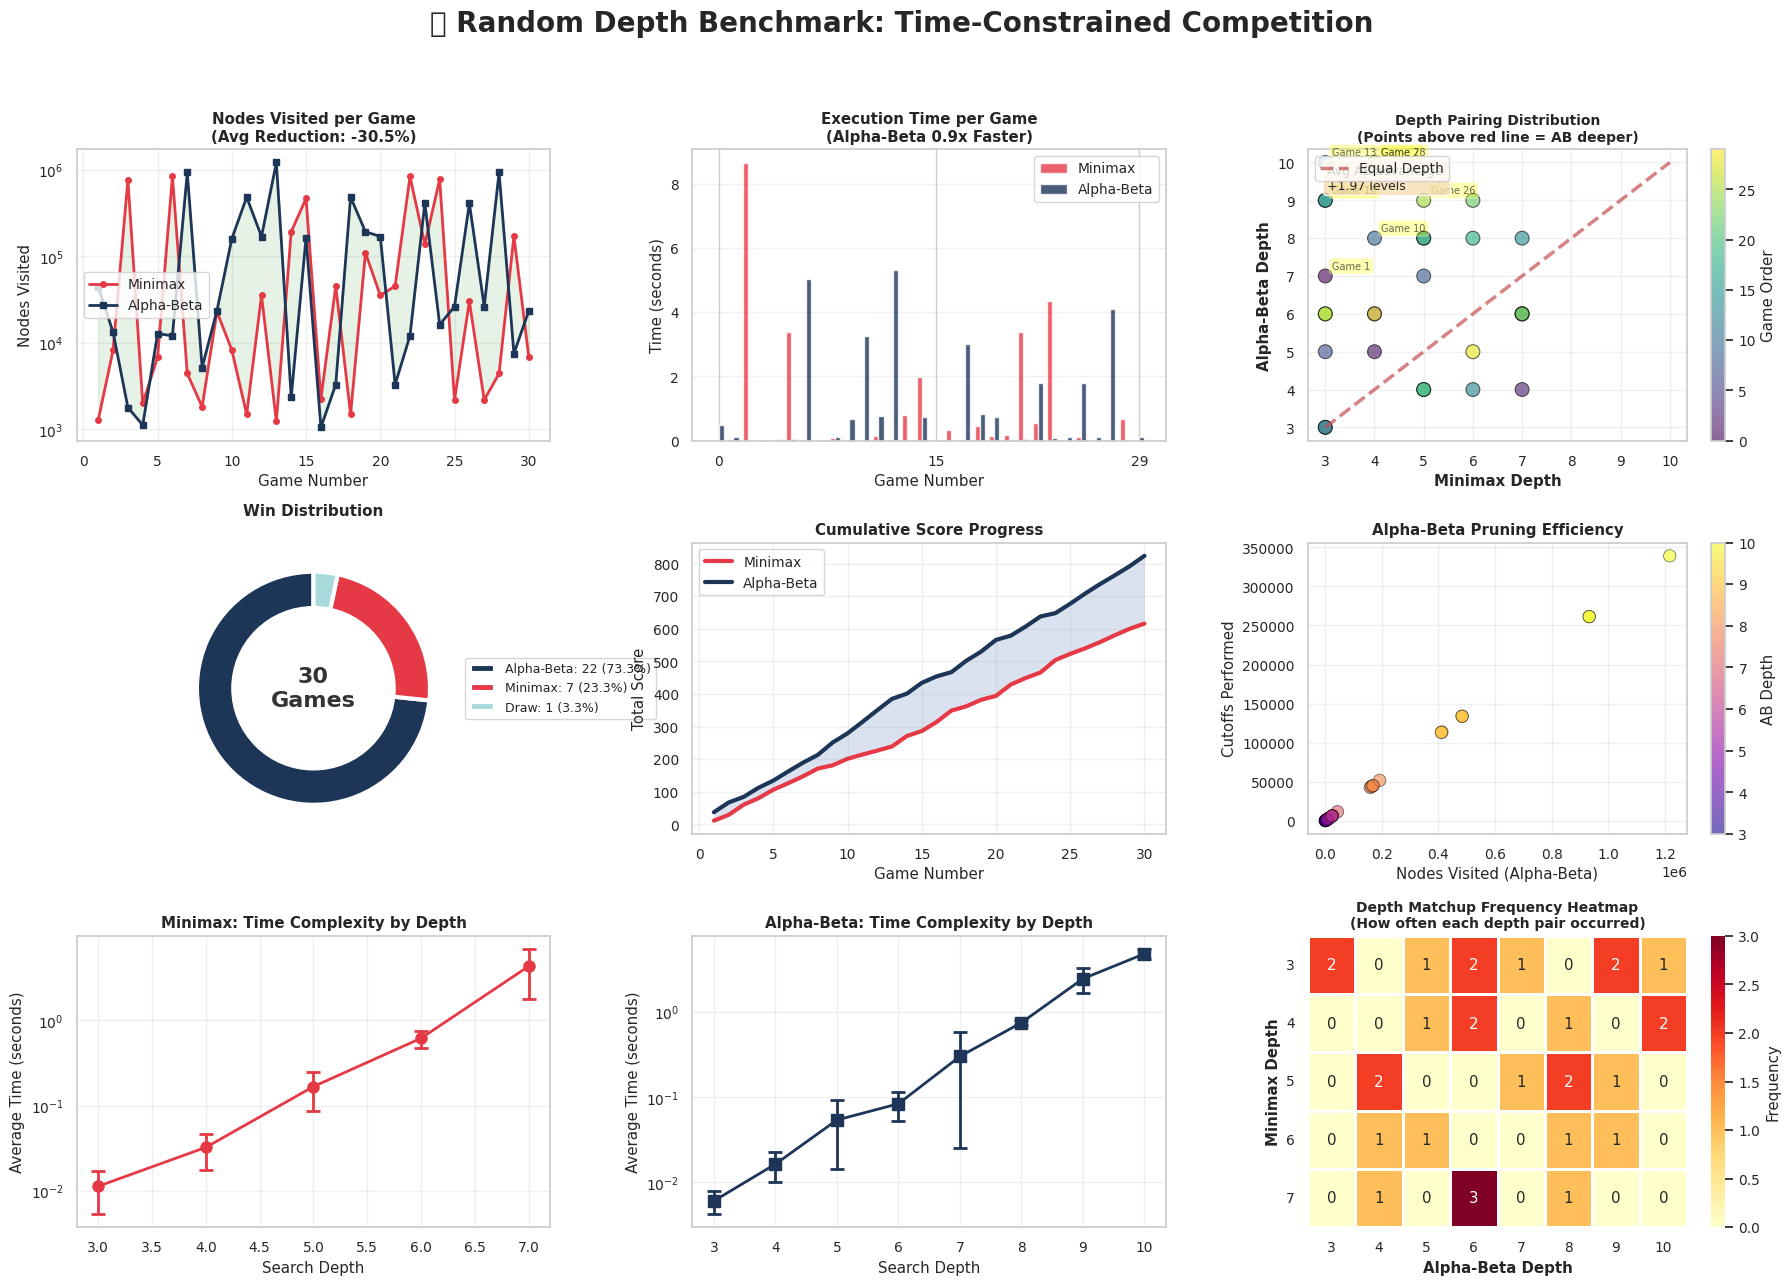

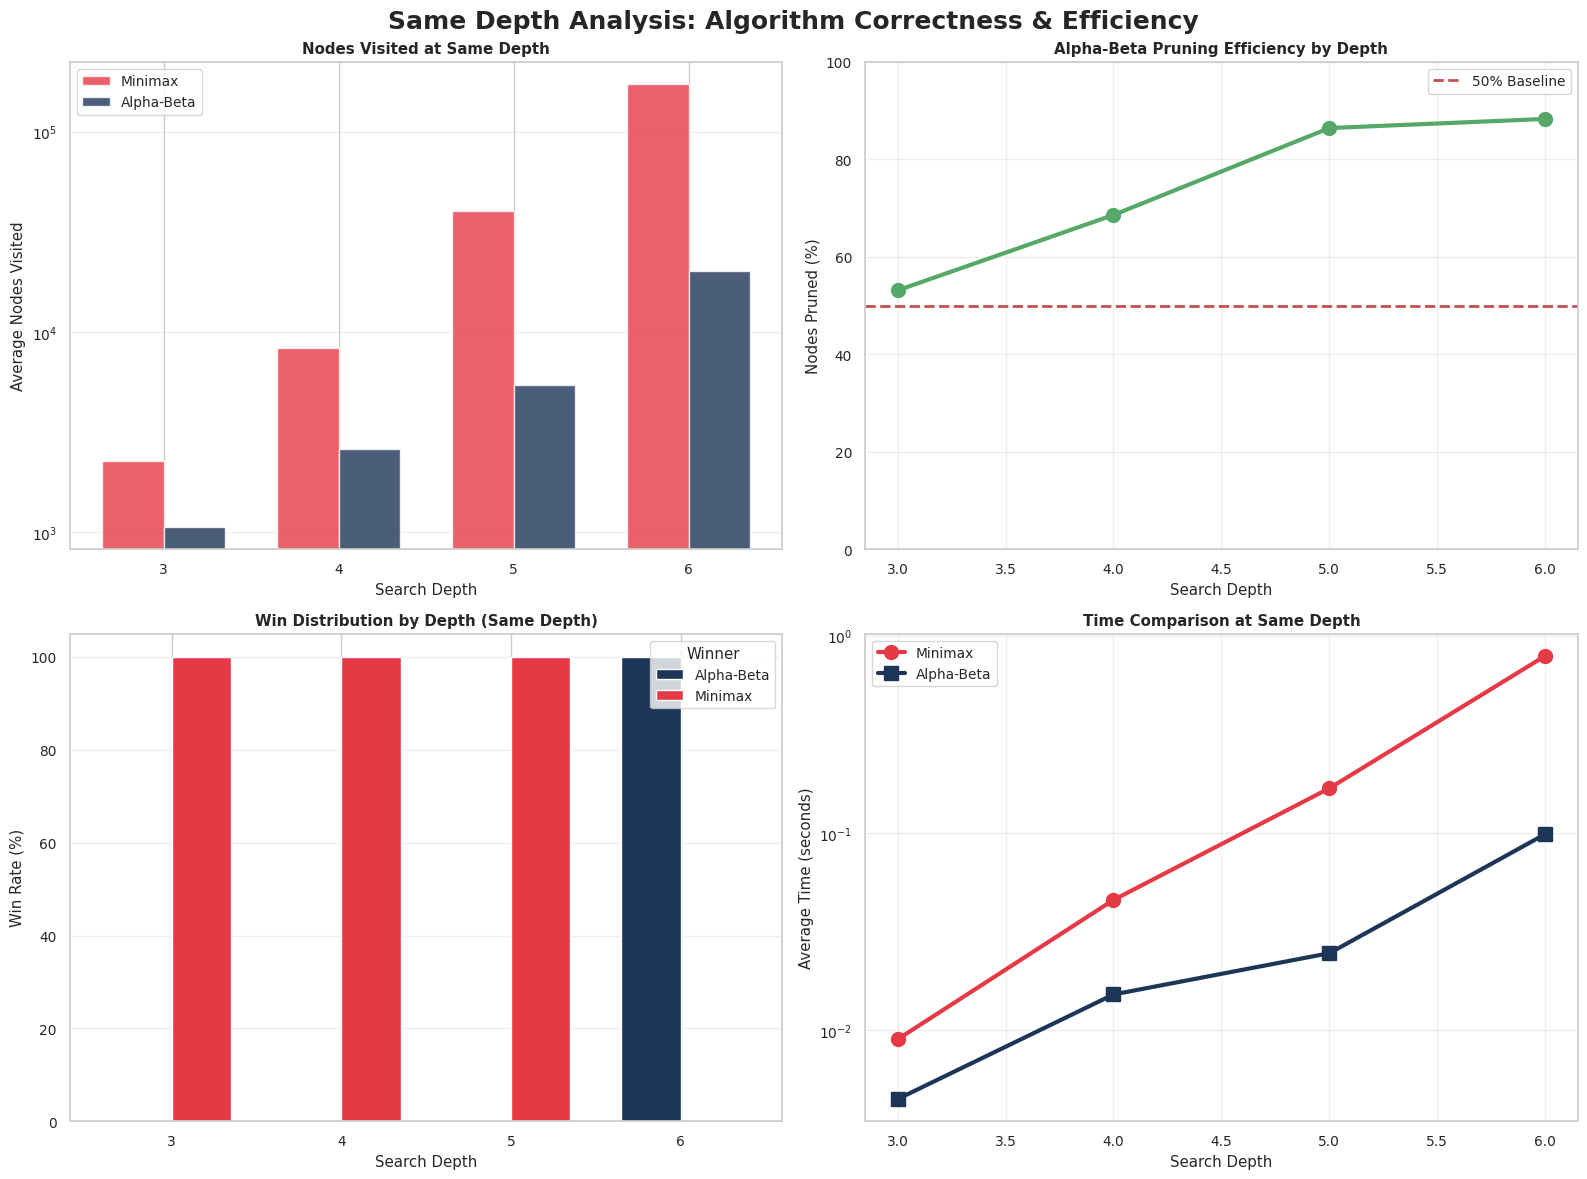

In [14]:
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    main()